In [1]:
# Функция, инициализирующая визуализацию прохода вагонопотока по станциям на графе
# selected_train = 
# train_visualisation(853)

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import  sched,time
%matplotlib inline

from datetime import datetime, timedelta

df_M = pd.read_json('data_one_day.json', orient='records')

In [3]:
all_stations = df_M['stations'][0]

In [4]:
# Заведем матрицу необходимого на день вагонопотока
all_stations_matrix = pd.DataFrame(all_stations)
all_stations_matrix_no_names = all_stations_matrix.rename(columns = {'Златоуст (1)' : '1', 'Кыштым (2)' : '2', 'Миасс (3)' : '3', 'Муслюмово (4)' : '4', 'Челябинск (5)' : '5', 'Полетаево (6)' : '6', 'Еманжелинск (7)' : '7'})
list_all_stations = all_stations_matrix_no_names.values.tolist()
list_all_stations

# Создание словаря all_stations
as_matrix_dict = {}

for row in range(len(list_all_stations)):
    for col in range(len(list_all_stations[0])):
        key = (col+1, row+1)
        as_matrix_dict[key] = list_all_stations[row][col]

In [5]:
# Функция расчета разницы времени
def calculate_timedelta_M(interval):
    start_time, end_time = interval.split(" - ")
    start_time = datetime.strptime(start_time, "%H:%M")
    end_time = datetime.strptime(end_time, "%H:%M")
    
    if end_time < start_time:
        end_time += timedelta(days=1)  # Добавляем 1 день к конечному времени, если оно меньше начального времени
    
    delta = end_time - start_time
    delta_hours = delta.seconds // 3600
    delta_minutes = (delta.seconds // 60) % 60
    
    return delta_hours*60 + delta_minutes

In [6]:
# Датафрейм с его поездами по расписанию
day_timetable = pd.DataFrame.from_dict(df_M['full_timetable'][0], orient='index')

# Посчитал дельты для всех поездов для станции
# table - day_timtable для кртакости
table = day_timetable
table['delta'] = day_timetable['timetable'].apply(lambda intervals: [calculate_timedelta_M(interval) for interval in intervals])
table = table.reset_index()

table['route_pairs'] = table['route'].apply(lambda x: [[x[i], x[i+1]] for i in range(len(x)-1)])

In [7]:
# Разбиваем список в колонках free_carriage и route_pairs на отдельные строки
table_new = table.explode(['free_carriage', 'route_pairs'])

# Создаем новую колонку с первым значением из каждой строки
table_new['stage'] = table_new.groupby('index').cumcount() + 1

# Выбираем нужные колонки и меняем порядок вывода
table_new = table_new[['index', 'route', 'timetable', 'delta', 'stage', 'free_carriage', 'route_pairs']]
table_new = table_new.reset_index()

table_new['rp_tuples'] = table_new['route_pairs'].apply(lambda x: tuple(x))


In [8]:
table_new['occupied_carriage'] = 0
table_new['total_carriage'] = 0
# Цикл заполняет колонку total_carriage значениями из первого словаря, а occupied_carriage - разница
for i, row in table_new.iterrows():
    key = tuple(map(int, row['rp_tuples']))
    if key in as_matrix_dict:
        table_new.at[i, 'total_carriage'] = int(as_matrix_dict[key])
        occupied = int(as_matrix_dict[key]) - int(row['free_carriage'])
        table_new.at[i, 'occupied'] = occupied
        
# table_new = table_new.drop('level_0', axis=1)


In [9]:
def visualisation_for_main_steps(train, step_num):
    occupied_for_main = 0
    # создаем граф
    G = nx.DiGraph()
    
    # Поменять если строка
    train_str = str(train)

    df = table_new.query("index == @train_str")
    rp_tuples_list = []

    counter = 0
    for i, row in df.iterrows():
        delta_list = row['delta']
        route = row['route']
        
        rp_tuples_list.append(row['rp_tuples'])
        
        
        if step_num == counter:
            node1_step = (row['rp_tuples'][0], delta_list[counter])
            node2_step = (row['rp_tuples'][1], delta_list[counter+1])
            G.add_edge(node1_step, node2_step, weight=row['occupied'])
            
            rp_tuples_for_main = row['rp_tuples']
            occupied_for_main = row['occupied']
        else:            
            node1 = (row['rp_tuples'][0], delta_list[counter])
            node2 = (row['rp_tuples'][1], delta_list[counter+1])
            G.add_edge(node1, node2, weight=0)
        counter += 1

#     pos = nx.spring_layout(G)
#     nx.draw(G, pos, with_labels=True)
#     labels = nx.get_edge_attributes(G, 'weight')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    if occupied_for_main < 0:
        occupied_for_main = 0
        
#     print(rp_tuples_list, rp_tuples_for_main, occupied_for_main)
    draw_main_graph(rp_tuples_list, rp_tuples_for_main, occupied_for_main)

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def draw_main_graph(selected_edges, step_edge, occupied_wagons):
    G = nx.MultiDiGraph()
    data = all_stations

    green_edges = []
    blue_edge = ()
    weight_edge = int(occupied_wagons)

    result = []
    for pair in selected_edges:
        key1, key2 = None, None
        for key, value in all_stations_keys_dict.items():
            if value == pair[0]:
                key1 = key
            elif value == pair[1]:
                key2 = key

            if key1 and key2:
                break

        if key1 and key2:
            result.append((key1, key2))

    key1 = next((k for k, v in all_stations_keys_dict.items() if v == step_edge[0]), None)
    key2 = next((k for k, v in all_stations_keys_dict.items() if v == step_edge[1]), None)
    blue_edge = (key1, key2)

    green_edges = result

    for city in data:
        G.add_node(city)

    for i, (city, values) in enumerate(data.items()):
        for j, value in enumerate(values):
            if value != '0':
                target_city = list(data.keys())[j]
                G.add_edge(city, target_city, weight=int(value), key=0)

    pos = nx.circular_layout(G)  # Изменили алгоритм расположения узлов на круговую компоновку
    plt.figure(figsize=(10, 10))  # Задаем размер графика

    edge_labels = nx.get_edge_attributes(G, 'weight')
    formatted_edge_labels = {}
    for (u, v, k), weight in edge_labels.items():
        label = f"{weight}"
        if (u, v) == blue_edge:
            label += f", {weight_edge}"
        formatted_edge_labels[(u, v, k)] = label

    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, edge_color="gray", alpha=0.8, arrows=True, connectionstyle='arc3, rad = 0.3')

    for (u, v, k), edge_attr in edge_labels.items():
        edge_color = 'green' if (u, v) in green_edges else 'orange'
        edge_color = 'blue' if (u, v) == blue_edge else edge_color  # Исправлено: заменено на else
        edge_width = 2.0 if (u, v) in green_edges else 1.0
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width=edge_width, alpha=1,
                               arrows=True, node_size=1000, connectionstyle='arc3, rad = 0.3')


    for edge, label in formatted_edge_labels.items():
        (u, v, k) = edge
        x0, y0 = pos[u]
        x1, y1 = pos[v]

        angle = np.arctan2(y1 - y0, x1 - x0)
        label_offset_x = 0.15 * np.sin(angle)
        label_offset_y = -0.15 * np.cos(angle)

        t = 0.5
        x, y = (1 - t) * x0 + t * x1, (1 - t) * y0 + t * y1

        if (u, v) == blue_edge:
            bbox_color = 'blue'
        else:
            if (u, v) in green_edges:
                bbox_color = 'green'
            else:
                bbox_color = 'orange'

        plt.text(x + label_offset_x, y + label_offset_y, label, fontsize=12, bbox=dict(facecolor=bbox_color, edgecolor='none', alpha=0.6))

    plt.axis("off")
    
    plt.title('Граф маршрутных точек для поезда 563 для дня номер 1')
    plt.show()
    
#     plt.clf()  # Очистка текущего графика
#     plt.plot(x, y)  # Перерисовка графика
#     print(edge_labels)


In [11]:
def train_visualisation( train_num):
    step_counter = 0
    max_steps = 10 #table_new.stage.max()
    while step_counter < max_steps:
        visualisation_for_main_steps(563, step_counter)
        time.sleep(1)
        step_counter += 1



In [12]:
# Зададим словарь названий и номеров
all_stations_keys_dict = {}
for key in all_stations:
    all_stations_keys_dict[key] = str(list(all_stations.keys()).index(key) + 1)

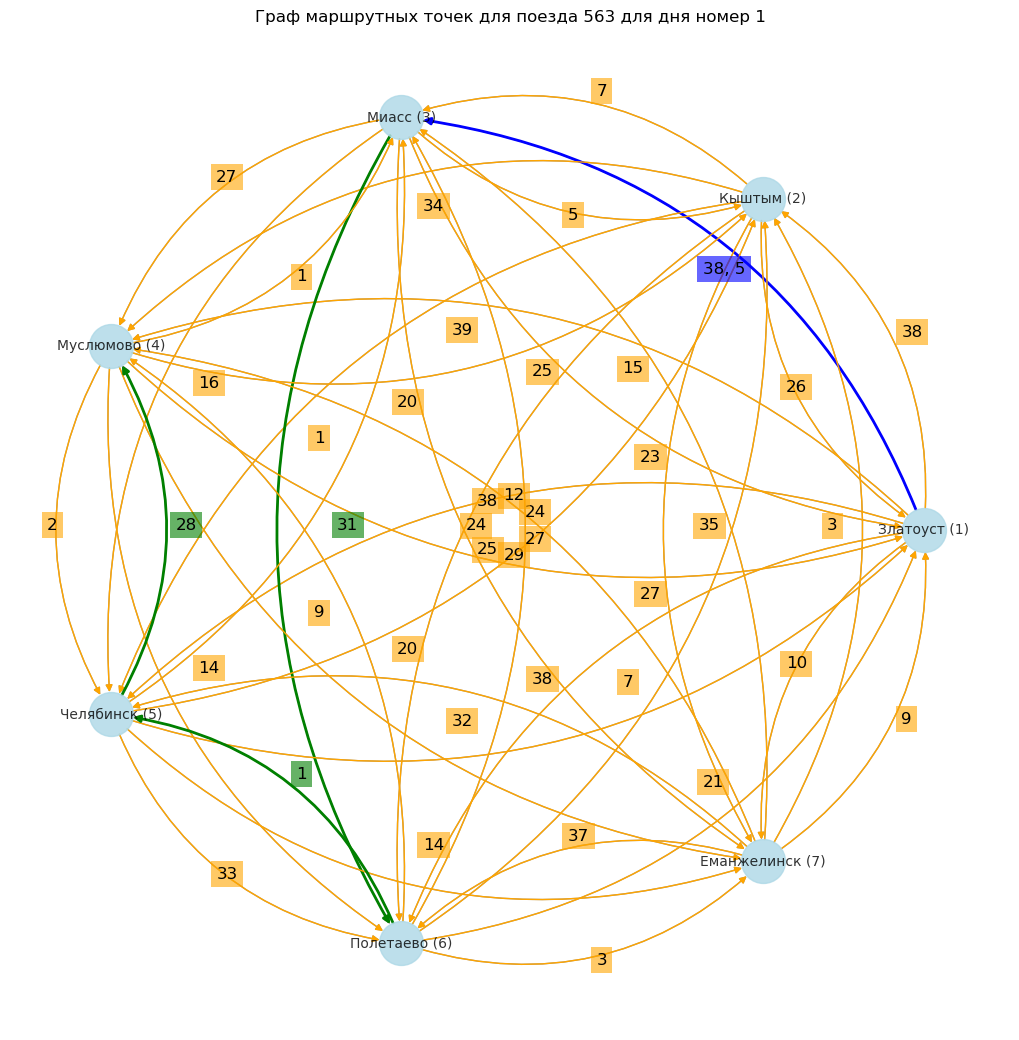

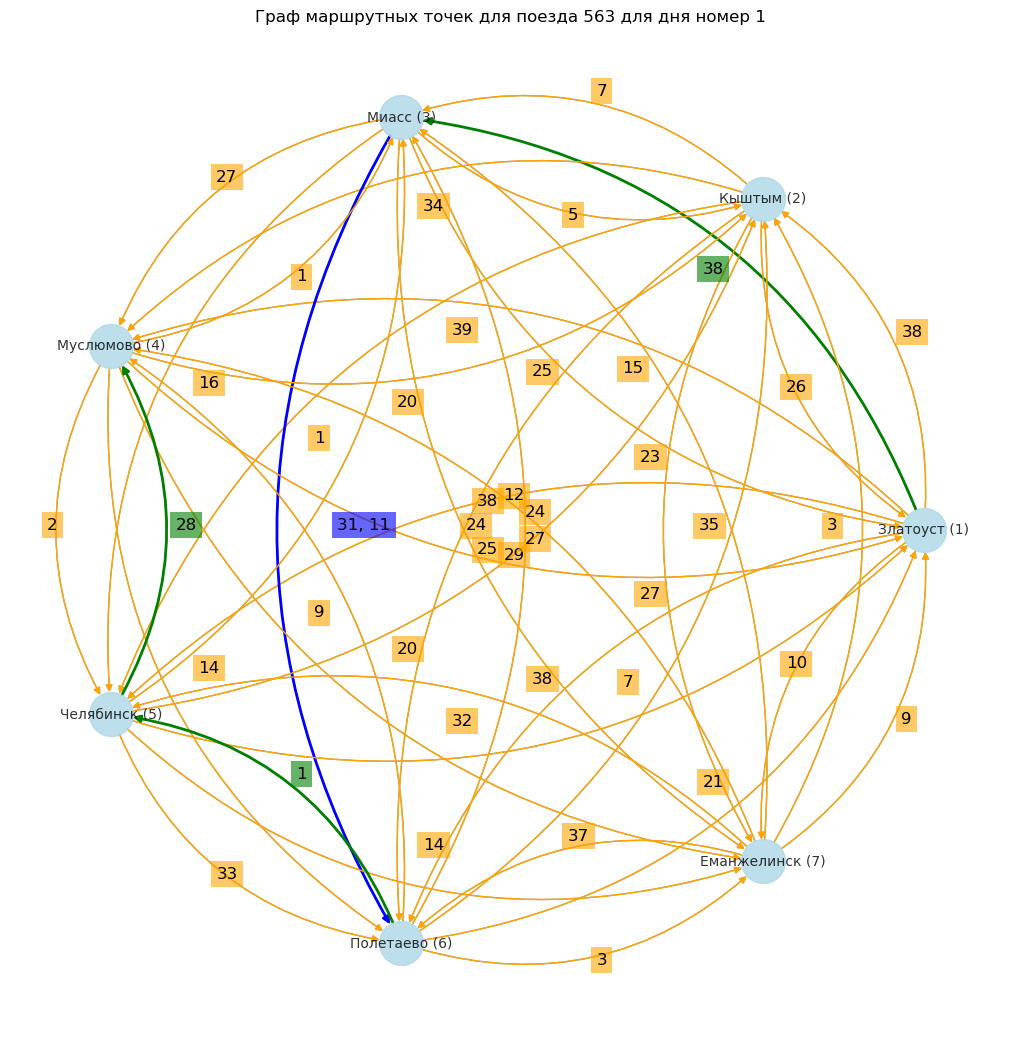

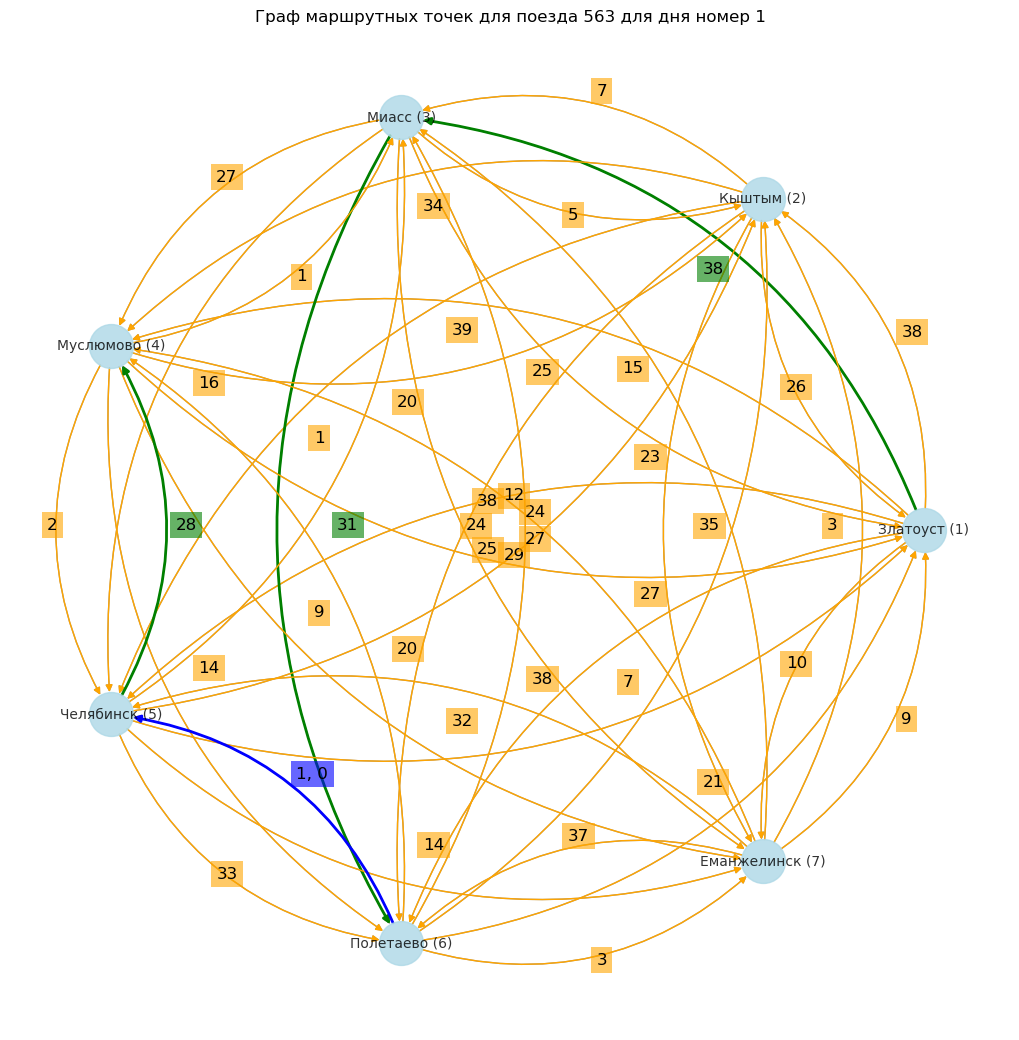

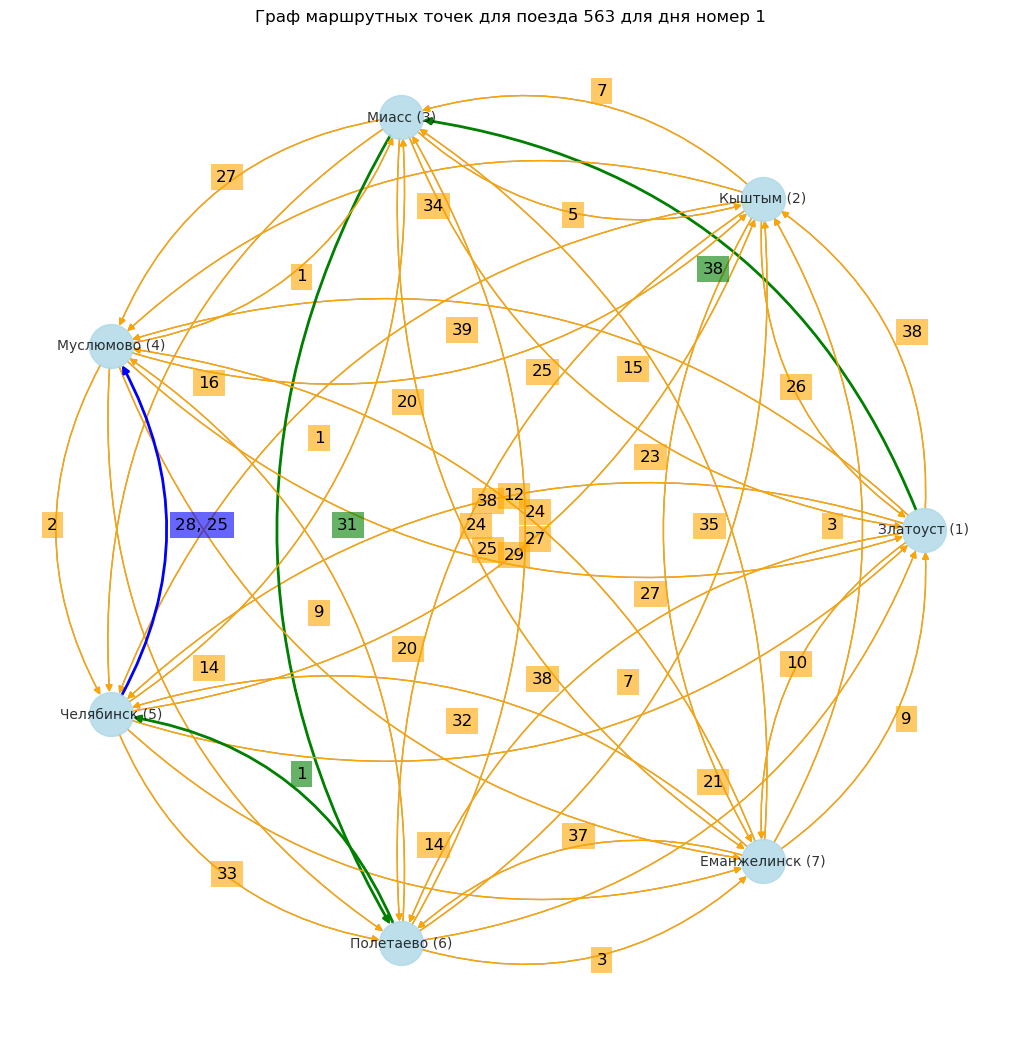

UnboundLocalError: cannot access local variable 'rp_tuples_for_main' where it is not associated with a value

In [13]:
train_visualisation(563)